In [1]:

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SEED = 40
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:

# 配置信息
class Cfg:
    data_root = './data'           # MNIST download/cache dir
    train_fraction = 0.10          # use 10% of the train split
    test_fraction  = 0.10          # use 10% of the test split
    train_num_pairs = 10000        # number of training pairs
    test_num_pairs  = 2000         # number of test pairs
    batch_size = 64
    epochs = 50
    lr = 1e-3
    weight_decay = 1e-4
    num_workers = 2
    save_dir = './output'
    model_name = 'siamese_mnist_same_digit.pth'
    # batch_log = 'batch_log.log'
    epoch_log = 'epoch_log.csv'

os.makedirs(Cfg.save_dir, exist_ok=True)
Cfg.__dict__


mappingproxy({'__module__': '__main__',
              'data_root': './data',
              'train_fraction': 0.1,
              'test_fraction': 0.1,
              'train_num_pairs': 10000,
              'test_num_pairs': 2000,
              'batch_size': 64,
              'epochs': 50,
              'lr': 0.001,
              'weight_decay': 0.0001,
              'num_workers': 2,
              'save_dir': './output',
              'model_name': 'siamese_mnist_same_digit.pth',
              'epoch_log': 'epoch_log.csv',
              '__dict__': <attribute '__dict__' of 'Cfg' objects>,
              '__weakref__': <attribute '__weakref__' of 'Cfg' objects>,
              '__doc__': None})

In [3]:

# Transforms预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 归一化[0,1], shape (1,28,28)
    transforms.Normalize((0.1307,), (0.3081,)),
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(Cfg.data_root, train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(Cfg.data_root, train=False, download=True, transform=transform)
print(f"原始训练集大小: {len(train_dataset)}")
print(f"原始测试集大小: {len(test_dataset)}")

# 抽取10%的数据
def sample_dataset(dataset, sample_ratio=0.1):
    indices = list(range(len(dataset)))
    sampled_indices = random.sample(indices, int(len(dataset) * sample_ratio))
    return Subset(dataset, sampled_indices)
train_subset = sample_dataset(train_dataset, Cfg.train_fraction)
test_subset = sample_dataset(test_dataset, Cfg.test_fraction)
print(f"采样后训练集大小: {len(train_subset)}")
print(f"采样后测试集大小: {len(test_subset)}")

# 创建配对数据集
class MNISTPairsDataset(Dataset):
    def __init__(self, subset, num_pairs):
        self.subset = subset
        self.num_pairs = num_pairs
        self.labels = [label for _, label in subset]
        self.images = [image for image, _ in subset]
        # 生成相同数字的索引映射
        label_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)
        # 创建配对
        self.pairs = []
        self.pair_labels = []
        for _ in range(num_pairs // 2):
            # 正样本对
            label = random.choice(list(label_to_indices.keys()))
            if len(label_to_indices[label]) >= 2:
                idx1, idx2 = random.sample(label_to_indices[label], 2)
                self.pairs.append((idx1, idx2))
                self.pair_labels.append(1)
            # 负样本对
            label1, label2 = random.sample(list(label_to_indices.keys()), 2)
            idx1 = random.choice(label_to_indices[label1])
            idx2 = random.choice(label_to_indices[label2])
            self.pairs.append((idx1, idx2))
            self.pair_labels.append(0)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        idx1, idx2 = self.pairs[idx]
        x1 = self.images[idx1]
        x2 = self.images[idx2]
        y = self.pair_labels[idx]
        return x1, x2, torch.tensor(y, dtype=torch.float32)

# 创建训练和测试配对数据集
train_pairs_dataset = MNISTPairsDataset(train_subset, num_pairs=Cfg.train_num_pairs)
test_pairs_dataset = MNISTPairsDataset(test_subset, num_pairs=Cfg.test_num_pairs)
print(f"训练配对数据集大小: {len(train_pairs_dataset)}")
print(f"测试配对数据集大小: {len(test_pairs_dataset)}")

# 检查正负样本比例
train_labels = [label for _, _, label in train_pairs_dataset]
test_labels = [label for _, _, label in test_pairs_dataset]
print(f"训练集正样本比例: {sum(train_labels) / len(train_labels):.3f}")
print(f"测试集正样本比例: {sum(test_labels) / len(test_labels):.3f}")

# 数据加载器
train_loader = DataLoader(train_pairs_dataset, batch_size=Cfg.batch_size, shuffle=True, num_workers=Cfg.num_workers)
test_loader = DataLoader(test_pairs_dataset, batch_size=Cfg.batch_size, shuffle=False, num_workers=Cfg.num_workers)

原始训练集大小: 60000
原始测试集大小: 10000
采样后训练集大小: 6000
采样后测试集大小: 1000
训练配对数据集大小: 10000
测试配对数据集大小: 2000
训练集正样本比例: 0.500
测试集正样本比例: 0.500


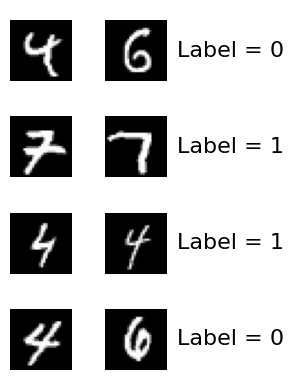

In [4]:
# 可视化一些配对样本
def show_pairs(ds: MNISTPairsDataset, n=4):
    # 创建三列：左图、右图和标签
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(3, 1*n))
    for i in range(n):
        x1, x2, y = ds[random.randint(0, len(ds)-1)]
        y = int(y.item())
        axes[i,0].imshow(x1.squeeze(0), cmap='gray')
        axes[i,0].axis('off')
        axes[i,1].imshow(x2.squeeze(0), cmap='gray')
        axes[i,1].axis('off')
        axes[i,2].text(0.5, 0.5, f'Label = {y}', fontsize=16, ha='center', va='center')
        axes[i,2].axis('off') 
    plt.tight_layout()
    plt.show()

show_pairs(train_pairs_dataset, n=4)

In [5]:

class ConvEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 1x28x28 -> 16x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> 32x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # -> 32x7x7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, emb_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

class SiameseSameDigit(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        self.encoder = ConvEncoder(emb_dim=emb_dim)
        # 使用绝对差和元素级乘积组合特征
        self.head = nn.Sequential(
            nn.Linear(emb_dim*2, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # logit
            nn.Sigmoid()  # 输出概率
        )

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        feat = torch.cat([torch.abs(z1 - z2), z1 * z2], dim=1)
        logit = self.head(feat)
        return logit.squeeze(1)  # (B,)
    
    def print_model_parameters(self):
        print(f"{'Layer Name':<40} {'Parameter Shape':<30} {'Param Count':<15}")
        print("=" * 85)
        total_params = 0
        for name, param in self.named_parameters():
            param_count = param.numel() 
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count:<15}")
        print("=" * 85)
        print(f"Total Parameters: {total_params}")

model = SiameseSameDigit(emb_dim=64).to(device)
model.print_model_parameters()


Layer Name                               Parameter Shape                Param Count    
encoder.features.0.weight                [16, 1, 3, 3]                  144            
encoder.features.0.bias                  [16]                           16             
encoder.features.3.weight                [32, 16, 3, 3]                 4608           
encoder.features.3.bias                  [32]                           32             
encoder.fc.1.weight                      [128, 1568]                    200704         
encoder.fc.1.bias                        [128]                          128            
encoder.fc.4.weight                      [64, 128]                      8192           
encoder.fc.4.bias                        [64]                           64             
head.0.weight                            [32, 128]                      4096           
head.0.bias                              [32]                           32             
head.2.weight                   

In [ ]:

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            outputs = model(x1, x2)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * y.size(0)
            preds = (outputs >= 0.5).float()
            total_correct += (preds == y.view_as(preds)).sum().item()
            total += y.size(0)
    return total_loss/total, total_correct/total

def train(model, train_loader, test_loader, epochs, lr, weight_decay):
    # loss_fn = nn.BCEWithLogitsLoss() # 内置sigmoid层
    loss_fn = nn.BCELoss() 
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    # log_file_path = os.path.join(Cfg.save_dir, Cfg.batch_log)

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for b, (x1, x2, y) in enumerate(train_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x1, x2)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds = (outputs >= 0.5).float()
                correct = (preds == y.view_as(preds)).sum().item()
                
            # batch_loss = loss.item()
            # batch_acc = correct / y.size(0)
            epoch_loss += loss.item() * y.size(0)
            epoch_correct += correct
            epoch_total += y.size(0)
            # test_loss_batch, test_acc_batch = evaluate(model, test_loader, loss_fn)
            # with open(log_file_path, 'a') as log_file:
            #     log_file.write(f"[epoch {epoch:2d}] [btach_idx {b:3d}] "+ 
            #                    f"batch_loss={batch_loss:.4f} batch_acc={batch_acc:.4f} | "+
            #                    f"test_loss={test_loss_batch:.4f} test_acc_batch={test_acc_batch:.4f}\n")

        train_loss = epoch_loss/epoch_total
        train_acc  = epoch_correct/epoch_total
        test_loss, test_acc = evaluate(model, test_loader, loss_fn)

        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)  
        history['test_acc'].append(test_acc)

        print(f"[Epoch {epoch:2d}] "+
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "+
              f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}")

    # print(f"Training log (mini-batch) saved to {log_file_path}")
    hist_df = pd.DataFrame(history)
    csv_path = os.path.join(Cfg.save_dir, Cfg.epoch_log)
    hist_df.to_csv(csv_path, index=False)
    print(f"Training log (epoch) saved to {csv_path}")
    model_path = os.path.join(Cfg.save_dir, Cfg.model_name)
    torch.save(model, model_path)
    print(f"Model saved to {model_path}")

    return history

history = train(model, train_loader, test_loader, Cfg.epochs, Cfg.lr, Cfg.weight_decay)


[Epoch  1] train_loss=0.6931 train_acc=0.4975 | test_loss=0.6930 test_acc=0.4945
[Epoch  2] train_loss=0.6929 train_acc=0.5157 | test_loss=0.6927 test_acc=0.5255
[Epoch  3] train_loss=0.6928 train_acc=0.5255 | test_loss=0.6924 test_acc=0.5405
[Epoch  4] train_loss=0.6925 train_acc=0.5363 | test_loss=0.6921 test_acc=0.5405
[Epoch  5] train_loss=0.6922 train_acc=0.5733 | test_loss=0.6916 test_acc=0.6445
[Epoch  6] train_loss=0.6919 train_acc=0.5534 | test_loss=0.6910 test_acc=0.6800
[Epoch  7] train_loss=0.6913 train_acc=0.5761 | test_loss=0.6902 test_acc=0.6235
[Epoch  8] train_loss=0.6904 train_acc=0.6291 | test_loss=0.6889 test_acc=0.6625
[Epoch  9] train_loss=0.6890 train_acc=0.6300 | test_loss=0.6868 test_acc=0.6620
[Epoch 10] train_loss=0.6867 train_acc=0.6157 | test_loss=0.6833 test_acc=0.6695
[Epoch 11] train_loss=0.6824 train_acc=0.6236 | test_loss=0.6769 test_acc=0.6695
[Epoch 12] train_loss=0.6743 train_acc=0.6402 | test_loss=0.6641 test_acc=0.6660
[Epoch 13] train_loss=0.6566

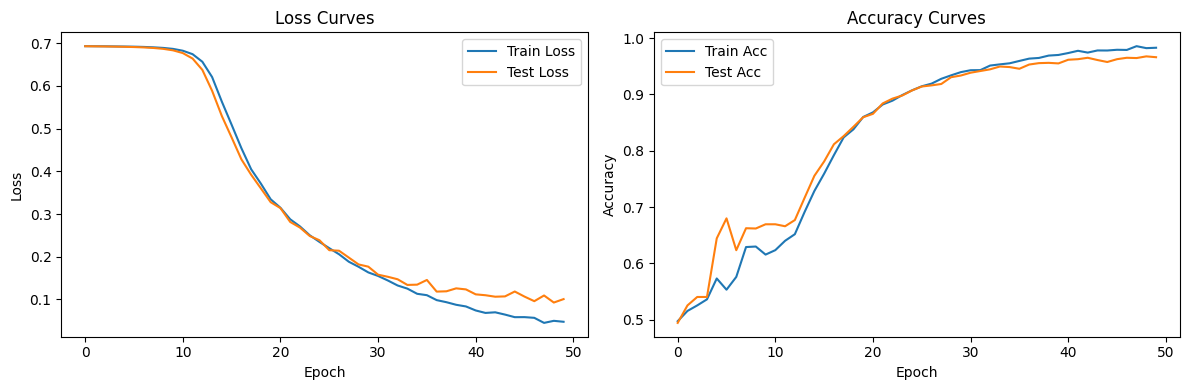

In [7]:
def plot_results(history):
    # 绘制损失和准确率曲线
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 左图：损失曲线
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['test_loss'], label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()

    # 右图：准确率曲线
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['test_acc'], label='Test Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_results(history)

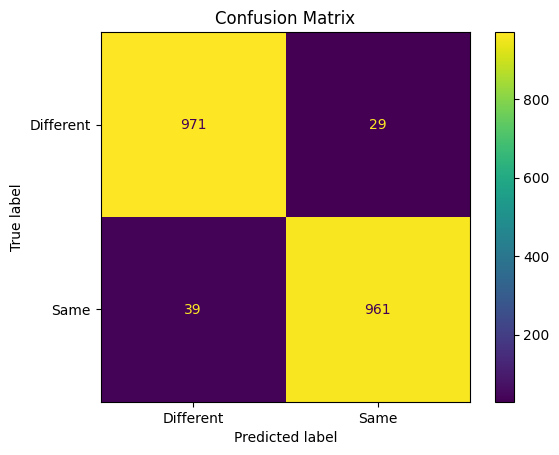

In [8]:

def plot_confusion_matrix(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            outputs = model(x1, x2)
            preds = (outputs >= 0.5).float()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader)

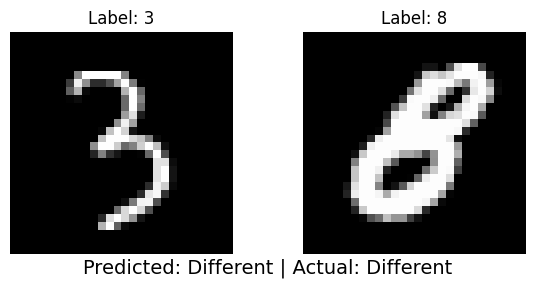

In [9]:
def predict_random_pair(model, test_subset):
    # 随机挑选两张图片
    idx1, idx2 = random.sample(range(len(test_subset)), 2)
    x1, label1 = test_subset[idx1]
    x2, label2 = test_subset[idx2]
    # 将图片转换为批量形式并移动到设备
    x1 = x1.unsqueeze(0).to(device)  # (1, 1, 28, 28)
    x2 = x2.unsqueeze(0).to(device)  # (1, 1, 28, 28)
    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(x1, x2)  # 输出 logits
        pred = 1 if output >= 0.5 else 0  # 二分类预测
    # 显示图片和预测结果
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(x1.cpu().squeeze(0).squeeze(0), cmap='gray')
    axes[0].set_title(f"Label: {label1}")
    axes[0].axis('off')
    axes[1].imshow(x2.cpu().squeeze(0).squeeze(0), cmap='gray')
    axes[1].set_title(f"Label: {label2}")
    axes[1].axis('off')
    result_text = f"Predicted: {'Same' if pred == 1 else 'Different'} | Actual: {'Same' if label1 == label2 else 'Different'}"
    fig.suptitle(result_text, fontsize=14, y=0.04)
    plt.tight_layout()
    plt.show()

model = torch.load(os.path.join(Cfg.save_dir, Cfg.model_name), map_location=device, weights_only=False)
model = model.to(device)
predict_random_pair(model, test_subset)